<a href="https://colab.research.google.com/github/MatteoAldovardi92/Taxi_Project/blob/main/MachineLearningPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [419]:
# To save a copy to be retrived from other notebooks
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [420]:
import pandas as pd
complete_df = pd.read_csv('/content/drive/MyDrive/datasets/complete_dataset.csv')
complete_df.head()



,trip_duration,dist_meters,wait_sec,city_id,mostly_rush_hour,means_velocity,geodetic_distance
0,14110,1700,461,mexico,False,0.120482,900.407793
1,681,2848,129,mexico,False,4.182085,1879.903684
2,436,1409,106,mexico,False,3.231651,963.009858
3,442,1567,85,mexico,False,3.545249,1048.168549
4,100,797,19,mexico,False,7.970000,340.570623


In [421]:
# Last time I forgot to take a look at means velocity and I didn't notice negative values
# and absurdely high values.
# I have to filter the velocities between 0 and 80
# I also forgot to filter the visibly erroneous waiting times.

mask_velocity = (complete_df['means_velocity']>0)*(complete_df['means_velocity']<80)

mask_wait = (complete_df['wait_sec'] < 3*3600) #Three hours of waiting are decisively too much

complete_df = complete_df[mask_velocity & mask_wait]

### Creation of a test set that I will never touch again until the webcall

In [422]:
# STEP 0: get rid of Rush hour I think it was poorly designed
complete_df = complete_df.drop(['mostly_rush_hour'], axis=1)


# STEP 1 — create the test set and keep track of the original indices
test_df = (
    complete_df
    .groupby('city_id')
    .apply(lambda x: x.sample(frac=0.15, random_state=42))
)

test_indices = test_df.index.get_level_values(1)  # original row indices


# STEP 2 — drop test samples from complete_df
train_df = complete_df.drop(index=test_indices)

# STEP 3 — clean up test_df index
test_df = test_df.reset_index(drop=True)



<ipython-input-422-66522f750a40>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.15, random_state=42))


In [423]:

test_df.to_csv('/content/drive/MyDrive/datasets/test_set.csv', index=False)
train_df.to_csv('/content/drive/MyDrive/datasets/train_set.csv', index=False)




## Look at the correlation between variables

In [424]:
y_df, X_df = train_df.iloc[:, 0], train_df.iloc[:, 1:]

<Axes: >

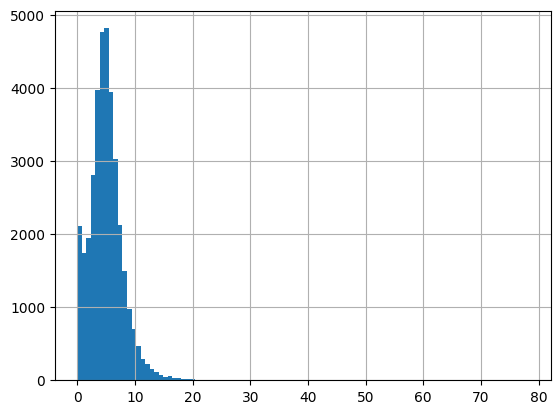

In [425]:
X_df['means_velocity'].hist(bins=100)

<Axes: >

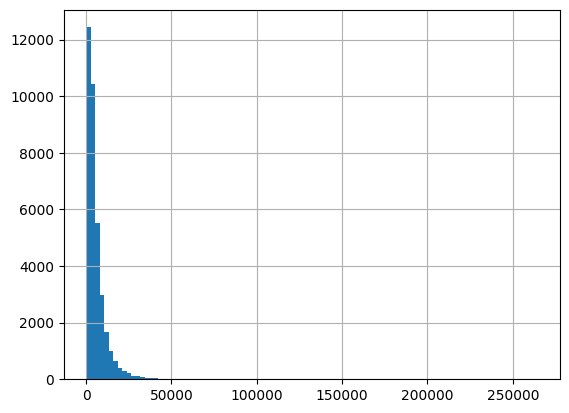

In [426]:
X_df['dist_meters'].hist(bins=100)

<Axes: >

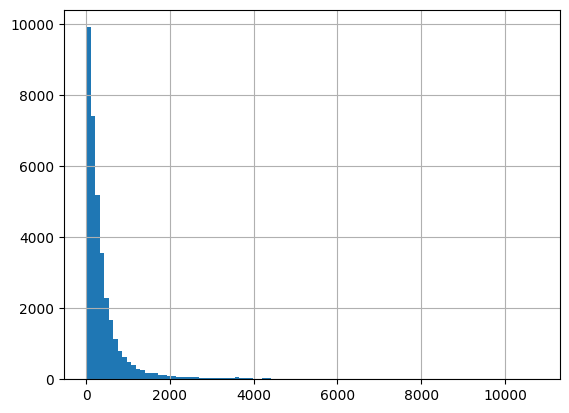

In [427]:
X_df['wait_sec'].hist(bins = 100)



<Axes: >

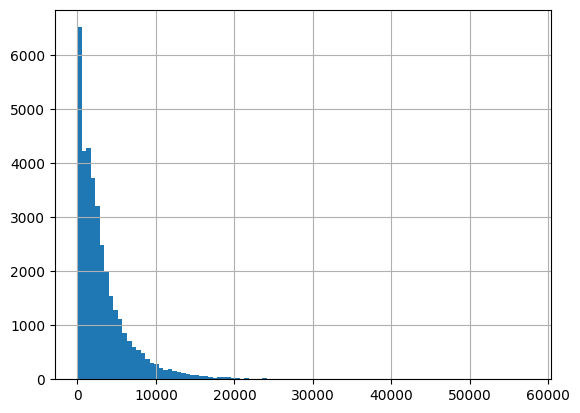

In [428]:
X_df['geodetic_distance'].hist(bins=100)

In [429]:
X_df['geodetic_distance'].describe()

,geodetic_distance
count,36144.000000
mean,3228.195299
std,3528.856233
min,0.000000
25%,918.872628
50%,2183.510417
75%,4264.738113
max,57435.528431


In [430]:
# STEP 1 — Create the validation set from X_df by sampling 15% within each city
val_df = (
    X_df
    .groupby('city_id', group_keys=False)
    .apply(lambda x: x.sample(frac=0.15, random_state=42))
)

# STEP 2 — Extract corresponding y values for the validation set
y_val = y_df.loc[val_df.index]

# STEP 3 — Drop validation samples from X_df and y_df to form training sets
X_df = X_df.drop(index=val_df.index)
y_df = y_df.drop(index=val_df.index)


<ipython-input-430-b5f85e4320bd>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.15, random_state=42))


In [431]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# STEP 1 — Create the validation set and remaining training set by splitting train_df
# using the same grouping and sampling logic as before, but applied to train_df directly.
# We will store the validation rows in val_df_split and the remaining training rows in train_df_split.
val_df_split = (
    train_df
    .groupby('city_id', group_keys=False)
    .apply(lambda x: x.sample(frac=0.15, random_state=42))
)

# STEP 2 — Drop validation samples from the original train_df to get the final training set
train_df_split = train_df.drop(index=val_df_split.index)

# STEP 3 — Separate features (X) and target (y) for both training and validation sets
# Ensure the column containing the target variable is consistently the first column (index 0)
# and features are the rest (index 1 onwards)
y_train = train_df_split.iloc[:, 0]
X_train = train_df_split.iloc[:, 1:]

y_val = val_df_split.iloc[:, 0]
X_val = val_df_split.iloc[:, 1:]


# Now proceed with normalization and one-hot encoding using X_train and X_val
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Define columns to normalize
features_to_normalize = ['means_velocity', 'dist_meters', 'wait_sec', 'geodetic_distance']

# 2. Select columns to normalize
X_train_norm = X_train[features_to_normalize]
X_val_norm = X_val[features_to_normalize]

# 3. Standardize numerical features
# Ensure the scaler is fit ONLY on the training data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_norm), columns=features_to_normalize, index=X_train.index)
# Transform validation data using the scaler fit on training data
X_val_scaled = pd.DataFrame(scaler.transform(X_val_norm), columns=features_to_normalize, index=X_val.index)

# 4. Get the rest of the features (assumed to be categorical or already preprocessed)
X_train_cat = X_train.drop(columns=features_to_normalize)
X_val_cat = X_val.drop(columns=features_to_normalize)

# 5. Convert categorical features to dummy variables (make sure to align train and val)
X_train_cat_dummies = pd.get_dummies(X_train_cat)
X_val_cat_dummies = pd.get_dummies(X_val_cat)

# 6. Align the columns of train and val sets (so they have the same dummy columns)
# Use join='outer' and fill_value=0 to ensure all dummy columns from both sets are present
# and filled with 0 if a category doesn't exist in one set.
X_train_cat_aligned, X_val_cat_aligned = X_train_cat_dummies.align(X_val_cat_dummies, join='outer', axis=1, fill_value=0)

# 7. Concatenate scaled numerical and aligned dummy categorical features
# Use the original indices from X_train and X_val to ensure alignment after concatenation
X_train_final = pd.concat([X_train_scaled, X_train_cat_aligned], axis=1).loc[X_train.index]
X_val_final = pd.concat([X_val_scaled, X_val_cat_aligned], axis=1).loc[X_val.index]

<ipython-input-431-f627bf0ba135>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.15, random_state=42))


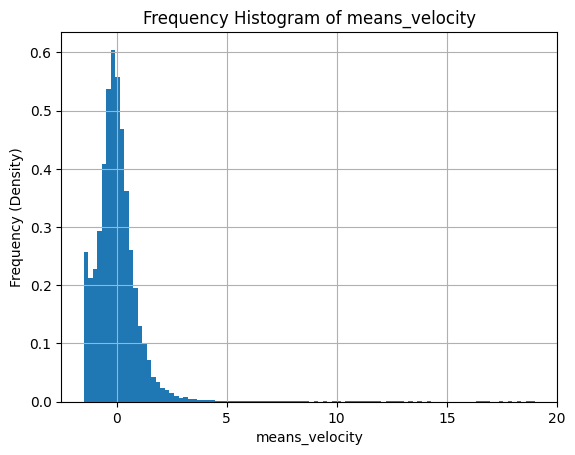

In [432]:
import matplotlib.pyplot as plt

X_train_final['means_velocity'].hist(bins=100, density=True)
plt.xlabel('means_velocity')
plt.ylabel('Frequency (Density)')
plt.title('Frequency Histogram of means_velocity')
plt.show()


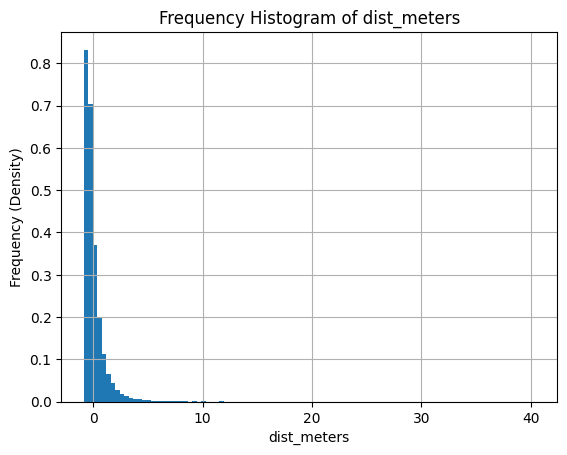

In [433]:
X_train_final['dist_meters'].hist(bins=100, density=True)
plt.xlabel('dist_meters')
plt.ylabel('Frequency (Density)')
plt.title('Frequency Histogram of dist_meters')
plt.show()

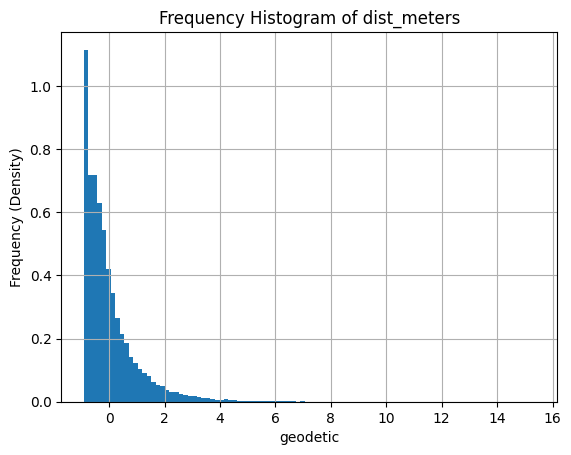

In [434]:
X_train_final['geodetic_distance'].hist(bins=100, density=True)
plt.xlabel('geodetic')
plt.ylabel('Frequency (Density)')
plt.title('Frequency Histogram of dist_meters')
plt.show()

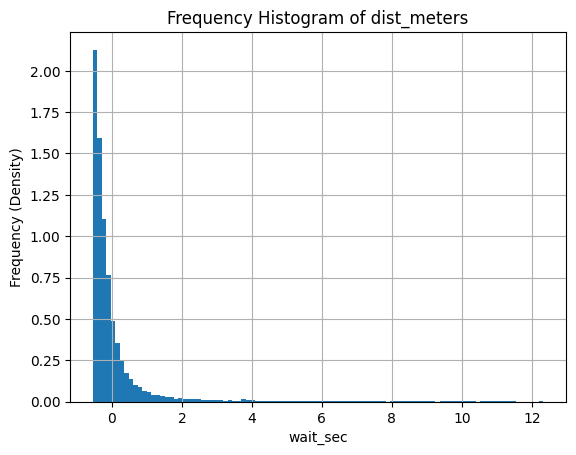

In [435]:
X_train_final['wait_sec'].hist(bins=100, density=True)
plt.xlabel('wait_sec')
plt.ylabel('Frequency (Density)')
plt.title('Frequency Histogram of dist_meters')
plt.show()

In [436]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge


degree = 3  # Tune the degree. Later I will using grid search

model = Pipeline([
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
    ('ridge', Ridge(alpha=1))
])


# Reshape y to 2D array for scaler
y_df = y_df.values.reshape(-1, 1)  # if y_train is a Series

scaler_y = StandardScaler()
y_df_scaled = scaler_y.fit_transform(y_df).ravel()  # back to 1D after scaling



model.fit(X_train_final, y_df_scaled)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('ridge', Ridge(alpha=1))])

In [437]:
model.named_steps['ridge'].coef_

array([-5.73754824e-01,  6.65231010e-01, -2.55594027e-01,  2.95990915e-02,
       -4.77334666e-03,  8.48405462e-03, -3.71070797e-03,  1.30129283e-01,
       -2.81692304e-01, -2.64689346e-01, -2.45215029e-02, -1.90045918e-01,
       -2.02470952e-01, -1.81237954e-01, -1.26616389e-02, -2.66767772e-02,
       -3.14225486e-03,  2.27227591e-01,  2.17759163e-01,  2.20244256e-01,
        6.43427887e-02, -1.66414883e-02, -7.35020450e-02, -5.53169186e-02,
       -1.26775063e-01, -3.29243499e-02, -8.26307593e-04,  2.27530194e-02,
        7.67237962e-03, -4.77334666e-03,  0.00000000e+00,  0.00000000e+00,
        8.48405462e-03,  0.00000000e+00, -3.71070797e-03, -7.01629768e-03,
        2.42585505e-02,  1.71004951e-02,  3.47423175e-03,  4.88080995e-02,
        4.50981374e-02,  3.62230459e-02,  1.19281427e-04,  2.53581758e-02,
        5.20882237e-02, -6.06538600e-02, -1.13585606e-01, -1.07452838e-01,
        2.03318453e-02, -2.88761882e-02, -1.16397569e-01, -1.74648670e-02,
       -1.30826911e-01, -

# Model evaluation


In [438]:
from sklearn.metrics import mean_squared_error, r2_score

y_val_scaled_pred = model.predict(X_val_final)

# Inverse transform to get predictions back in original scale
y_val_pred = scaler_y.inverse_transform(y_val_scaled_pred.reshape(-1, 1)).ravel()
# Evaluate performance

mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {mse:.4f} or {mse/3600:.4f}h")
print(f"Validation R²: {r2:.4f}")


#The model does a really poor job at explaing the variance in the data, and
# the coefficients are really near to zero when there is even the tiny bitzy
# of regularization and they explode without it!

Validation MSE: 1936194.5263 or 537.8318h
Validation R²: 0.4051
